### Deep learning in pytorch
We'll perform use pytorch to train a classifier to identify 131 different objects in images.

The dataset is the [Fruits 360 collection](https://www.kaggle.com/moltean/fruits) of images from 131 categories. There are about 500 - 1000 images in each category.

In [ ]:
# torch Facebook
import torch
import torchvision
from torchvision import datasets , transforms
from torch import cuda
# Useful for examining network
from torchsummary import summary
# tools
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14
import warnings
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import sys
import seaborn as sns
import glob

import time
import copy
import sys


# Image manipulations
from PIL import Image

# Timing utility
from timeit import default_timer as timer
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
# connect google dirve
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

multi_gpu = None
# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [ ]:
# path data (location of data)
root = "/content/drive/MyDrive/Project /Fruits_Classfication/fruits-360"
train_path = root + "/" + "Training"
test_path = root + "/" + "Test"

### Data Exploration
We can do exploration of the availiable images.We can show the distribution, evaluation quality the images ...

In [ ]:
# load data manually
# create empty list
categories = []
img_categories = []
n_train = []
n_test = []
hs = []
ws = []

# Interate through each category

for cls in tqdm(os.listdir(train_path)):
  
  categories.append(cls)

  # number image of each categories
  train_imgs = os.listdir(os.path.join(train_path,cls))
  test_imgs = os.listdir(os.path.join(test_path,cls))
  n_train.append(len(train_imgs))
  n_test.append(len(test_imgs))

  # Find stats for train image
  for e_img in train_imgs:
    img_categories.append(cls)
    img = Image.open(os.path.join(train_path,cls,e_img))
    img_arr = np.array(img)
    hs.append(img_arr.shape[0])
    ws.append(img_arr.shape[1])


# Dataframe of categories
df_Cat = pd.DataFrame({"Categories" : categories,"n_train": n_train, "n_test": n_test}).\
sort_values("Categories")

# DataFrame of train images
img_df = pd.DataFrame({"categories" : img_categories,"width": ws,"height" : hs})

df_Cat.sort_values("n_train",ascending = False,inplace = True)
df_Cat.head()

100%|██████████| 131/131 [7:03:56<00:00, 194.17s/it]


Categories  n_train  n_test
44         Grape Blue      984     328
103            Plum 3      900     304
80            Peach 2      738     246
116  Strawberry Wedge      738     246
120          Tomato 1      738     246

In [ ]:
df_Cat.to_csv(os.path.join(root,"df_cat.csv"))
img_df.to_csv(os.path.join(root,"img_df.csv"))

Text(0.5, 1.0, 'Training Images by Category')

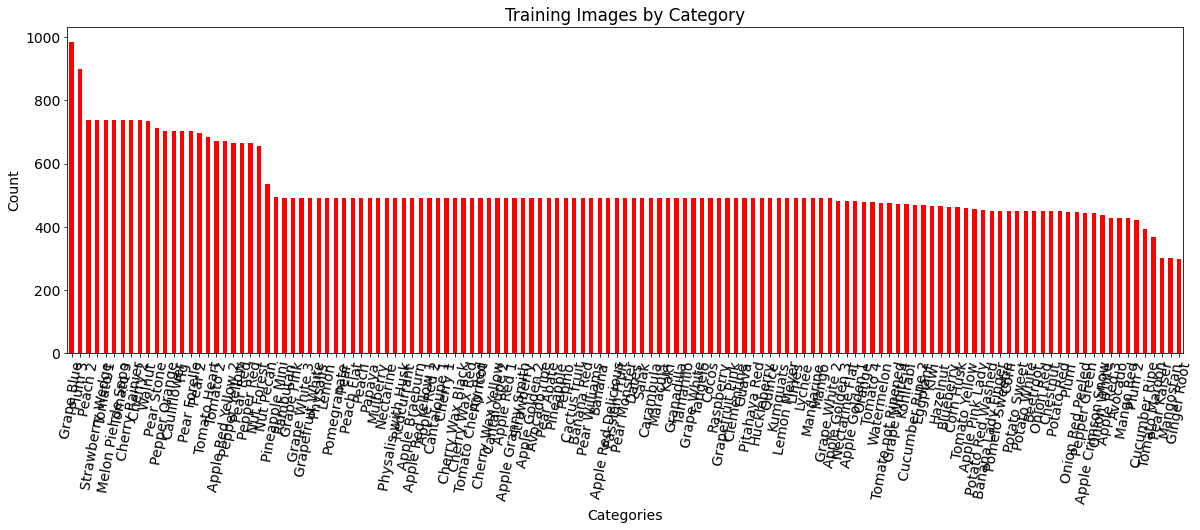

In [ ]:
# Distribution of image each category
df_Cat.set_index('Categories')['n_train'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

Text(0.5, 1.0, 'Training Images by Category')

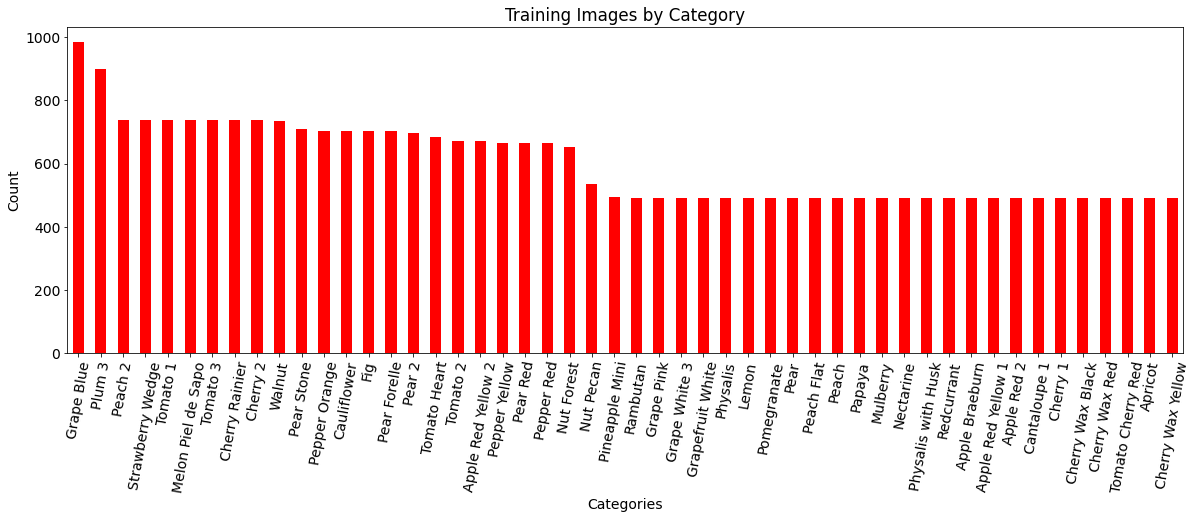

In [ ]:
# Only top 50 categories
df_Cat.set_index('Categories').iloc[:50]['n_train'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

In [ ]:
#Distribution of Images Sizes
img_dsc = img_df.groupby('categories').describe()
img_dsc.head()

width                     ... height                     
                    count   mean  std    min  ...    25%    50%    75%    max
categories                                    ...                            
Apple Braeburn      492.0  100.0  0.0  100.0  ...  100.0  100.0  100.0  100.0
Apple Crimson Snow  444.0  100.0  0.0  100.0  ...  100.0  100.0  100.0  100.0
Apple Golden 1      480.0  100.0  0.0  100.0  ...  100.0  100.0  100.0  100.0
Apple Golden 2      492.0  100.0  0.0  100.0  ...  100.0  100.0  100.0  100.0
Apple Golden 3      481.0  100.0  0.0  100.0  ...  100.0  100.0  100.0  100.0

[5 rows x 16 columns]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Average Size Distribution')

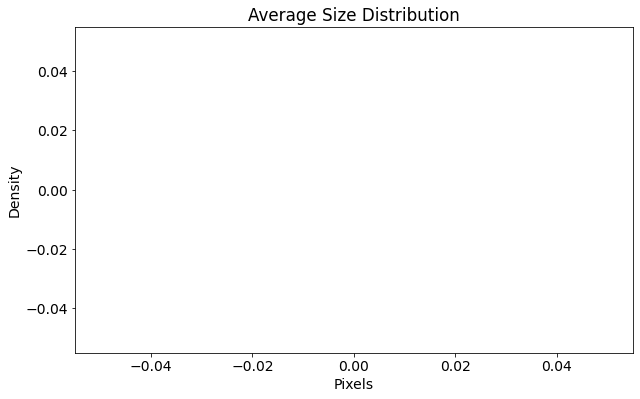

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(
    img_dsc['height']['mean'], label='Average Height')
sns.kdeplot(
    img_dsc['width']['mean'], label='Average Width')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Size Distribution')


In [ ]:
def imshow(image):
  """ Display image """
  plt.figure(figsize = (6,6))
  plt.imshow(img)
  plt.axis("off")
  plt.show()



### Image Preprocessing
To prepare the images for our network, we have to resize them to 224x224 and normalize each color channel by subtracting a mean value and dividing by a standard deviation. These operations are done using image `transforms`.

#### Data Augmentation

We can use image augmentation to artificially increase the number of images. This means for training, we randomly resiz and crop the images and also flip the horzontally. A different random transformation is applied each epoch (while training).

In [ ]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

transforms_tensor = transforms.Compose([transforms.ToTensor()])

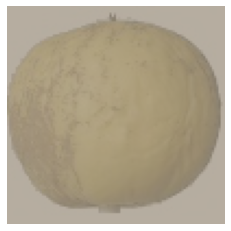

In [ ]:
# Examples of augmentation

def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))  # only image format tensor

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    # return ax, image

sample = Image.open("/content/drive/MyDrive/Project /Fruits_Classfication/fruits-360/Training/Apple Golden 1/162_100.jpg")

imshow_tensor(transforms_tensor(sample))

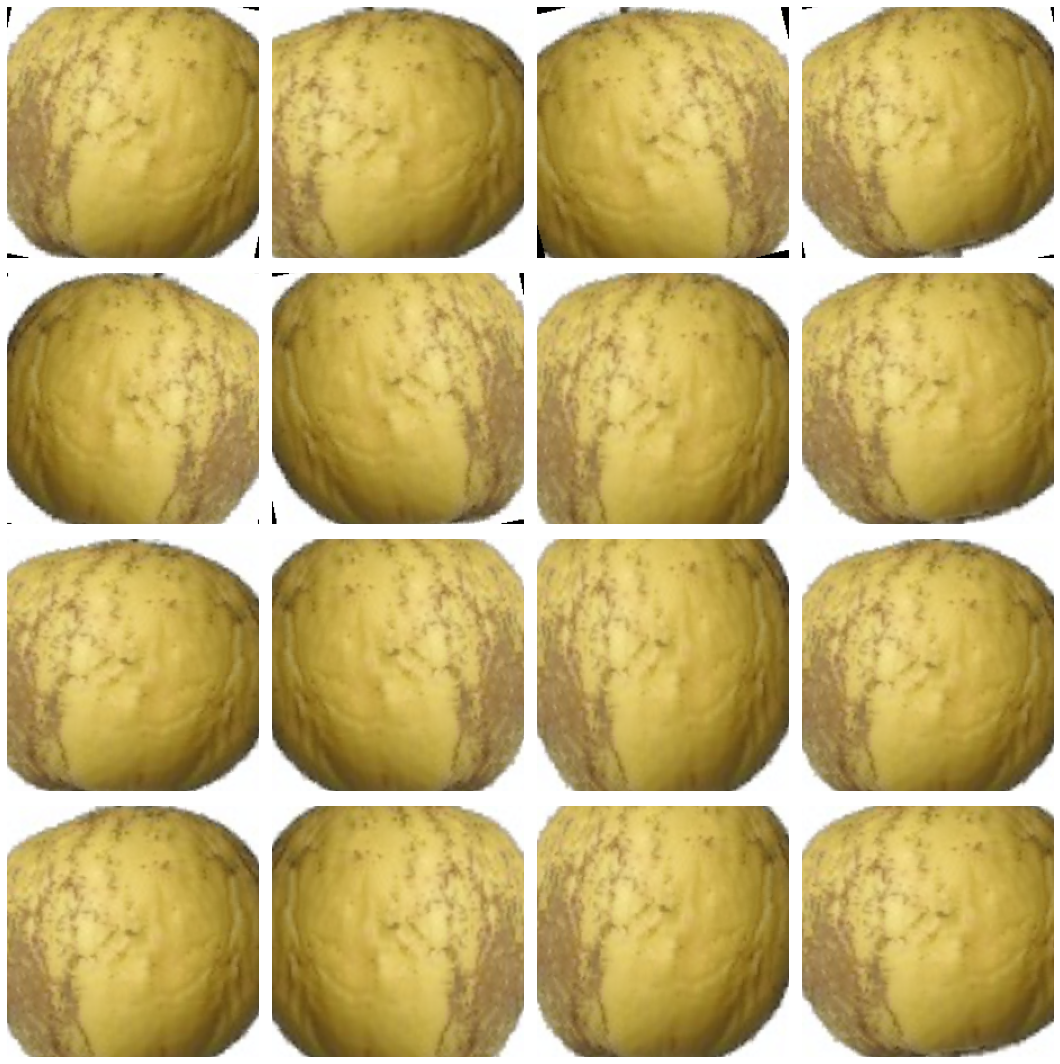

In [ ]:
# augmentation data train
t = image_transforms['train']
plt.figure(figsize=(15,15))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(sample), ax=ax)

plt.tight_layout()

### Load data in folder (Data Iterators)
At  the training time, the DataLoader will load the images from disk, apply the transformations, and yield a batch. To train and validation, we'll iterate through all the batches in the respective DataLoader.


In [ ]:
torch.manual_seed(17)# setup

transform = transforms.Compose([transforms.transforms.ToTensor()])
transform

Compose(
    ToTensor()
)

In [ ]:
# list file in root
for folder in os.listdir(root):
  print(folder)

LICENSE
readme.md
Test
Training
papers
test-multiple_fruits
model
torchv4.ckpt
df_cat.csv
img_df.csv
checkpoint
evaluate.csv


In [ ]:
# split test and validations data in folder Test
from torch.utils.data.sampler import SubsetRandomSampler

# check data for training
train_data = datasets.ImageFolder(os.path.join(root,"Training"),transform=transform)
test_data = datasets.ImageFolder(os.path .join(root,"Test"),transform=transform)

random_seed = 42 
shuffle_dataset = True
val_split = 0.5 # split 50%
data_size = len(test_data)
indices = list(range(data_size))
split = int(np.floor(val_split * data_size)) # np.floor round to int


if shuffle_dataset:
  np.random.seed(random_seed)
  np.random.shuffle(indices)

test_indices , val_indices = indices[split:], indices[:split]

test_sampler = SubsetRandomSampler(test_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [ ]:
# datasets from each folder
batch_size = 16
num_worker = 4 

data = {
    "train": datasets.ImageFolder(train_path,transform= image_transforms["train"]),
    "test" : datasets.ImageFolder(test_path,transform = image_transforms["test"])
}

# dataloader iterators
# distribution data for training
dataloaders = { # if use sampler then have not option shuffle data
    "train": torch.utils.data.DataLoader(data["train"],batch_size=batch_size,shuffle = True , num_workers= num_worker),
    "val": torch.utils.data.DataLoader(data["test"],batch_size=batch_size , sampler=val_sampler, num_workers=num_worker), 
    "test" : torch.utils.data.DataLoader(data["test"],batch_size= batch_size ,sampler=test_sampler)
}
dataset_sizes = {"train": len(data["train"]) ,"val": len(val_sampler) ,"test" : len(test_sampler)}

class_names = data["train"].classes
dataset_sizes

{'test': 11344, 'train': 67692, 'val': 11344}

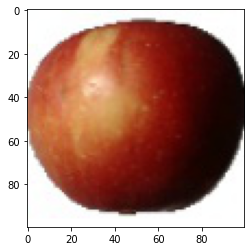

In [ ]:
dt = datasets.ImageFolder(os.path.join(root,"Training")) # load data without transform to tensor therefore data format Image PIL
plt.imshow(dt[0][0])

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 67692
    Root location: /content/drive/MyDrive/Project /Fruits_Classfication/fruits-360/Training
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
number_class = len(train_data.classes)
print("Number of class: {}".format(number_class))
input_shape = train_data[0][0].shape
print("Size image: {}".format(input_shape))

Number of class: 131
Size image: torch.Size([3, 100, 100])


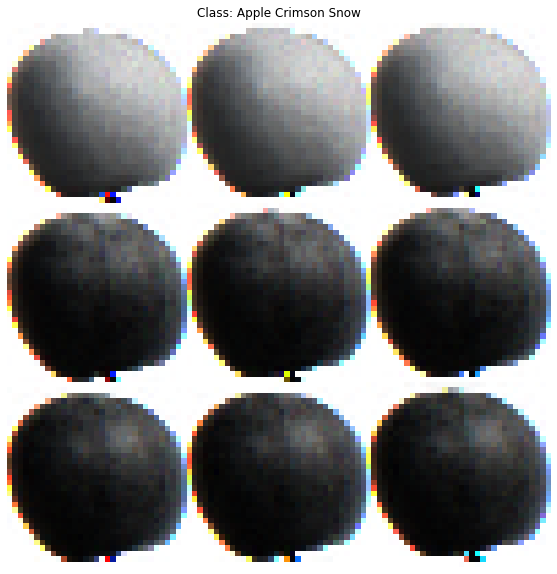

In [ ]:
# plot image

import matplotlib.pyplot as plt
index = 656 # index label

def get_class(train_data,index):
  for key, value in  train_data.class_to_idx.items():
    if value == train_data[index][1]:
      return key

  return "None"

class_name = get_class(data["train"],index)
plt.figure(figsize = (10,10))
plt.imshow(train_data[index][0].reshape(100,100,-1)) # error use reshape tensor
plt.axis("off")
plt.title(f"Class: {class_name}");

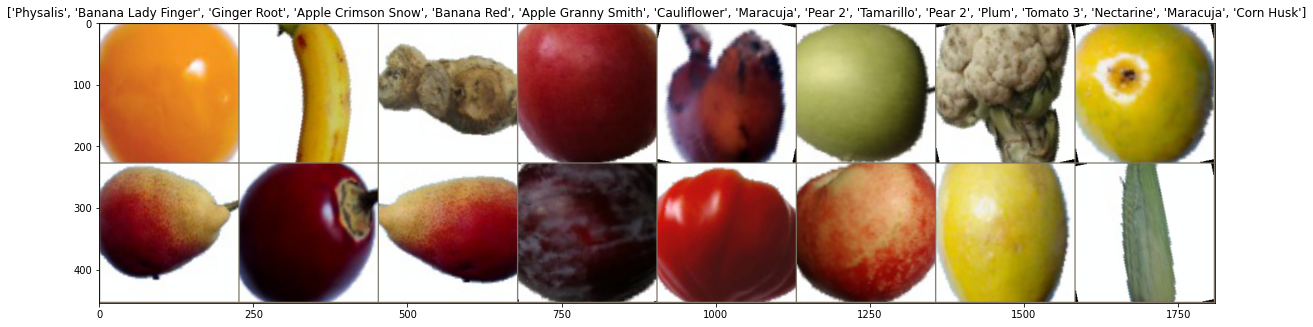

In [ ]:
def imshow_gridtensor(inp, title=None,figsize = (20,10)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize= figsize )
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow_gridtensor(out, title=[class_names[x] for x in classes])

In [ ]:
trainiter = iter(dataloaders["train"])
features , labels = next(trainiter)
features.shape , labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))


This construction avoids the need to load all the data into memory and also will automatically apply the transformations to each batch. One each epoch, the Random transformation will be different so the network will essentially see multiple version of each training image.

### Pre-Trained models for image classification

What we want to do with pretrained models is freeze the earky layer, and replace the classification module with our own.

Pre-trained networks have proven to be reasonably successful for a variety tasks and results in a significant reduction in training time and usually increases in performance.

In [ ]:
# Vgg16 pretrain 
model_name = ["vgg16_transfer",  "vgg16_scratch"]
num_epochs = 9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# training model
def train_model(model, criterion, optimizer, scheduler, save_file_name = None, num_epochs=25,max_epochs_stop =3 ):
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    valid_best_acc = 0.0
    valid_best_loss = np.Inf
    # early stopping intialization
    epochs_no_improve = 0
    history = []

    best_epoch = 0
    start_epoch = 0
    try:
      print(f"=========== Resumming training from {model.epochs} epochs ==================")
      start_epoch = model.epochs
      num_epochs += start_epoch
    except:
      model.epochs = 0
      print(f"=========== Strarting training form scratch. ================")

    for epoch in range(start_epoch ,num_epochs):
        results_ = []

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else: # dont need to keep track of gradients
                model.eval()   # Set model to evaluate mode

            # keep track of training and validation loss accuracy  each epoch
            running_loss = 0.0
            running_corrects = 0
            


            # Iterate over data.
            with tqdm(dataloaders[phase], unit="batch", desc='Epoch {}/{}'.format(epoch, num_epochs) , file=sys.stdout) as data:
              for inputs, labels in data:
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  # labels = nn.functional.one_hot(labels,num_classes=number_class)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      #predict ouputs are log probabilities
                      outputs = model(inputs)
                      
                      _, preds = torch.max(outputs, 1)
                      # calculate loss
                      loss = criterion(outputs, labels)

                      # backward + optimize only if in training phase
                      if phase == 'train':
                          # backpropagation of gradients
                          loss.backward()

                          # update the parameters
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)

                  # calculate accuracy train and valid by finding max log probability
                  correct_tensor = preds.eq(labels.data.view_as(preds))
                  # Need to convert correct tensor from int to float to average
                  accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

                  running_corrects += accuracy.item() * inputs.size(0)
                  # running_corrects += torch.sum(preds == labels.data) # only use for output is int (not transform to softmax)
                  
              if phase == 'train':
                  scheduler.step()

              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects / dataset_sizes[phase] # has no attribute double                              

              results_.append(epoch_acc)
              results_.append(epoch_loss)
              if phase == "val":
                history.append(results_)

              print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                  phase, epoch_loss, epoch_acc))

              # deep copy the model if validation loss decreases
              if phase == 'val' and epoch_loss < valid_best_loss:
                # track improvement
                epochs_no_improve = 0
                valid_best_acc = epoch_acc
                valid_best_loss = epoch_loss
                best_epoch = epoch
                # save weight best
                best_model_wts = copy.deepcopy(model.state_dict())
                  
              # otherwise increment count of epochs with no improment
              elif phase == "val":
                epochs_no_improve += 1
                # trigger early stopping 

                if epochs_no_improve >= max_epochs_stop:
                  print(f"\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with Validation loss: {valid_best_loss:.2f} and accuracy: {100 * valid_best_acc:.2f} %")

                  # load the best state dict
                  model.load_state_dict(best_model_wts)

                  # Format history
                  history = pd.DataFrame(history,
                                         columns = ["train_acc" ,"train_loss" , "val_acc" ,"val_loss" ])

                  return model , history

            # print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best validation Acc: {:4f} and best validation loss: {:4f}'.format(valid_best_acc,valid_best_loss))

    history = pd.DataFrame(history, columns = ["train_acc" ,"train_loss" , "val_acc" ,"val_loss" ])
    # load best model weights
    model.load_state_dict(best_model_wts)
    if save_file_name:
        print("Don't save!")
   
    return model , history 


In [ ]:
# pytorch v3 None softmax
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

model_ft = models.vgg16(pretrained= True)
# model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=number_class)

#Freeze Early layers

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
for param in  model_ft.parameters():
  param.requires_grad = False

n_inputs = model_ft.classifier[6].in_features

# Add on classifier
model_ft.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, number_class), nn.LogSoftmax(dim=1))

model_ft.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=131, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [ ]:
total_params = sum(p.numel() for p in model_ft.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

135,343,043 total parameters.
1,082,499 training parameters.


In [ ]:
# Move to GPU
if train_on_gpu:
    model_ft = model_ft.to('cuda')

if multi_gpu:
    model_ft = nn.DataParallel(model_ft)

In [ ]:
# torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch import Tensor

# load model
class VGG16(nn.Module):
  def __init__(self,name_model , pretrained = True):
    super(VGG16,self).__init__()

    self.md = 0
    if (name_model == "vgg16_scratch" or pretrained == False):
      self.model_vgg = models.vgg16(pretrained= pretrained)
      self.model_vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=number_class)
    if (name_model == "vgg16_transfer" and pretrained == True):
      # finetuning the convnet
      self.model_vgg = models.vgg16(pretrained= pretrained)
      self.md = 1
      # Freeze  early layers
      for  param in self.model_vgg.parameters() :
        param.requires_grad = False

      input_next = self.model_vgg.classifier[6].in_features
      # add on classifier
      self.model_vgg.classifier[6] = nn.Sequential(
          nn.Linear(input_next,512) , nn.ReLU(), nn.Dropout(0.2),
          nn.Linear(512,number_class), nn.LogSoftmax(dim =1)
      )


    # Move to gpu and parallelize
    if train_on_gpu:
      self.model_vgg = self.model_vgg.to(device)

    if multi_gpu:
      self.model_vgg = nn.DataParallel(self.model_vgg)
  def forward(self,x : Tensor):
    x = self.model_vgg(x)
    if (self.md == 0):
      x = F.log_softmax(x)
    return x

In [ ]:
vgg = VGG16(model_name[1]) # vgg16_scratch and vgg16_transfer
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG16(
  (model_vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [ ]:
# torchsummary library
if multi_gpu:
  summary(
      vgg.modules, input_size = (3,224,224),
      batch_size = batch_size,
      device = "cuda"
  )
else:
  summary(
      vgg, input_size = (3,224,224),
      batch_size = batch_size,
      device = "cuda"
  )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 224, 224]           1,792
              ReLU-2         [16, 64, 224, 224]               0
            Conv2d-3         [16, 64, 224, 224]          36,928
              ReLU-4         [16, 64, 224, 224]               0
         MaxPool2d-5         [16, 64, 112, 112]               0
            Conv2d-6        [16, 128, 112, 112]          73,856
              ReLU-7        [16, 128, 112, 112]               0
            Conv2d-8        [16, 128, 112, 112]         147,584
              ReLU-9        [16, 128, 112, 112]               0
        MaxPool2d-10          [16, 128, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]         295,168
             ReLU-12          [16, 256, 56, 56]               0
           Conv2d-13          [16, 256, 56, 56]         590,080
             ReLU-14          [16, 256,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
if multi_gpu :
  print(vgg.modules.classifier[-1])
else:
  print(vgg.model_vgg.classifier[-1])

Linear(in_features=4096, out_features=131, bias=True)


#### Mapping of classes to indexes

To keep track of the predictions made by the model.

In [ ]:

class_to_idx = data["train"].class_to_idx
idx_to_class = {
    idx: class_
    for class_, idx in class_to_idx.items()
}

list(idx_to_class.items())[:5]

[(0, 'Apple Braeburn'),
 (1, 'Apple Crimson Snow'),
 (2, 'Apple Golden 1'),
 (3, 'Apple Golden 2'),
 (4, 'Apple Golden 3')]

#### Training loss , optimizer and scheduler

The final output will be log probabilities which we can then use in the Negative Log Likelihood loss.

In [ ]:
# vgg = vgg.to(device)  
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#### Training

In [ ]:
if __name__ == '__main__' :
  num_epochs = 9
  model_best , history = train_model(vgg, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=num_epochs)

=========== Strarting training form scratch. ================
Epoch 0/9:   0%|          | 0/4231 [00:00<?, ?batch/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0/9: 100%|██████████| 4231/4231 [1:55:28<00:00,  1.64s/batch]
train Loss: 0.2922 Acc: 0.9237
Epoch 0/9: 100%|██████████| 709/709 [19:01<00:00,  1.61s/batch]
val Loss: 0.0674 Acc: 0.9824
Epoch 1/9: 100%|██████████| 4231/4231 [18:35<00:00,  3.79batch/s]
train Loss: 0.0210 Acc: 0.9943
Epoch 1/9: 100%|██████████| 709/709 [01:02<00:00, 11.30batch/s]
val Loss: 0.0917 Acc: 0.9808
Epoch 2/9: 100%|██████████| 4231/4231 [18:34<00:00,  3.79batch/s]
train Loss: 0.0124 Acc: 0.9970
Epoch 2/9: 100%|██████████| 709/709 [01:07<00:00, 10.46batch/s]
val Loss: 0.0163 Acc: 0.9959
Epoch 3/9: 100%|██████████| 4231/4231 [18:34<00:00,  3.80batch/s]
train Loss: 0.0085 Acc: 0.9978
Epoch 3/9: 100%|██████████| 709/709 [01:00<00:00, 11.78batch/s]
val Loss: 0.0428 Acc: 0.9893
Epoch 4/9: 100%|██████████| 4231/4231 [18:34<00:00,  3.80batch/s]
train Loss: 0.0054 Acc: 0.9985
Epoch 4/9: 100%|██████████| 709/709 [01:00<00:00, 11.74batch/s]
val Loss: 0.0317 Acc: 0.9931
Epoch 5/9: 100%|██████████| 4231/4231 [18:34<00:

In [ ]:
print(optimizer_ft.state_dict())

{'state': {}, 'param_groups': [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'initial_lr': 0.001, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]}]}


#### Training results 

Text(0.5, 1.0, 'Training and Validation losses')

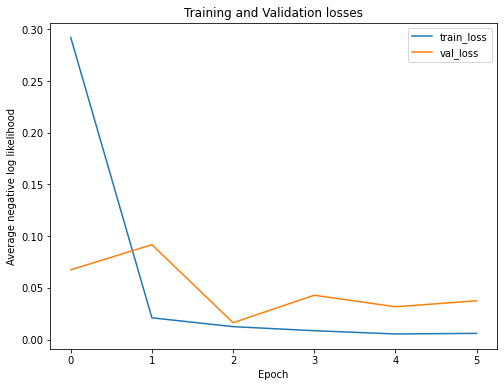

In [ ]:
plt.figure(figsize = (8,6))
for typ in ["train_loss", "val_loss"]:
  plt.plot(history[typ] , label = typ)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average negative log likelihood")
plt.title("Training and Validation losses")

Text(0.5, 1.0, 'Training and Validation accuracy')

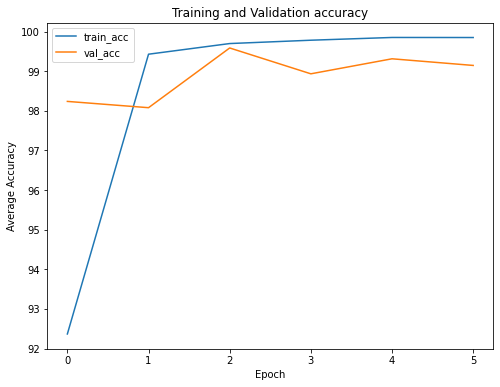

In [ ]:
plt.figure(figsize = (8,6))
for typ in ["train_acc", "val_acc"]:
  plt.plot(100 * history[typ] , label = typ)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Accuracy")
plt.title("Training and Validation accuracy")

#### Saveing Model

The train function saves the best model `state_dict()` which are the weight of the model.


In [ ]:
model_best.md

1

In [ ]:
def save_checkpoint(model, path):
  """ Save a pytorch model checkpoint (https://pytorch.org/tutorials/beginner/saving_loading_models.html)"""

  model_name = path.split("/")[-1].split(".")[0].split("-")[0]
  print(model_name)
  assert (model_name in ["vgg16_transfer" , "vgg16_scratch"]) , "Path must have the correct model name"

  # Basic details
  checkpoint = {
      "class_to_idx" : class_to_idx,
      "idx_to_class" : idx_to_class,
      "epochs" : num_epochs
  }

  # Extract the final classifier  and state dictionary
  if model_name == "vgg16_scratch" or  model_name == "vgg16_transfer":
    # check to see if model was parallelized
    if multi_gpu:
      # checkpoint["classifier"] = model.module.classifier  # dont neccessary 
      checkpoint["state_dict"] = model.module.state_dict()

    else:
      # checkpoint["classifier"] = model.classifier # dont neccessary 
      checkpoint["state_dict"] = model.state_dict()

  # checkpoint["loss"] = criterion
  # add the optimizer (important for resuming training (recheck))
  if False:
    checkpoint["optimizer"] = optimizer_ft
    checkpoint["optimizer_state_dict"] = optimizer_ft.state_dict()

    checkpoint["state_loss"] = criterion
    checkpoint["loss"] = criterion.state_dict()
    
    checkpoint["scheduler"] = exp_lr_scheduler
    checkpoint["lr_scheduler"] = exp_lr_scheduler.state_dict()
  
  # save the data to the path with file extension .pt or .pth
  # Note : save all very big file
  torch.save(checkpoint,path)
 

In [ ]:
path_out = os.path.join(root,"checkpoint")
if not os.path.exists(path_out):
  os.mkdir(path_out)
save_checkpoint(model_best, os.path.join(path_out,"vgg16_transfer-v1.pth"))

vgg16_transfer


In [ ]:
path_out = os.path.join(root,"checkpoint")
if not os.path.exists(path_out):
  os.mkdir(path_out)
save_checkpoint(model_best, os.path.join(path_out,"vgg16_scratch-v1.pth"))

vgg16_scratch


#### Load in a Checkpoint
* We can use this model to contrinue training

In [ ]:
path_out = os.path.join(root,"checkpoint")
name_checkpoint = "vgg16_transfer-v1.pth"
name_checkpoint_scratch = "vgg16_scratch-v1.pth"

def load_checkpoint(path,resumming =False):
  """ Load a pytorch model checkpoint"""
  
  model_name = path.split("/")[-1].split(".")[0].split("-")[0]
  print(model_name)
  assert (model_name in ["vgg16_transfer" , "vgg16_scratch"]) , "Path must have the correct model name"

  checkpoint = torch.load(path)

  if model_name == "vgg16_scratch":
    model = VGG16(model_name)

    # model.classifier = checkpoint["classifier"]
  elif model_name == "vgg16_transfer":
    model = VGG16(model_name)

  # load in the state dict
  model.load_state_dict(checkpoint["state_dict"])

  total_params = sum(p.numel() for p in model.parameters())
  print(f"{total_params:,} total parameters.")
  total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f"{total_trainable_params:,} training parameters.")

  # Move to GPU
  if train_on_gpu:
      model = model.to('cuda')

  if multi_gpu:
      model = nn.DataParallel(model)

  # Model basics
  model.class_to_idx = checkpoint["class_to_idx"] # add attritude for class model
  model.idx_to_class = checkpoint["idx_to_class"]
  model.epochs = checkpoint["epochs"]

  # Optimizer
  # if resumming: # dont necessary
  #   optimizer = checkpoint["optimizer"]
  #   optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

  #   lr_scheduler = checkpoint["scheduler"]
  #   lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])
    
  #   criterion = checkpoint["state_loss"]
  #   criterion.load_state_dict(checkpoint["loss"])


  model.train()
  return model


In [ ]:
vgg  = load_checkpoint(os.path.join(path_out, name_checkpoint),resumming  = True)

vgg16_transfer
136,425,411 total parameters.
2,164,867 training parameters.


In [ ]:
vgg  = load_checkpoint(os.path.join(path_out, name_checkpoint_scratch),resumming  = True)

vgg16_scratch
134,797,251 total parameters.
134,797,251 training parameters.


In [ ]:
# resumming training 
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 6 # only  use model state dict 
model_best , history = train_model(vgg, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=num_epochs,max_epochs_stop = 3)

=========== Resumming training from 9 epochs ==================
Epoch 9/15:   0%|          | 1/4231 [00:00<59:30,  1.18batch/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 9/15: 100%|██████████| 4231/4231 [18:35<00:00,  3.79batch/s]
train Loss: 0.0094 Acc: 0.9975
Epoch 9/15: 100%|██████████| 709/709 [01:00<00:00, 11.71batch/s]
val Loss: 0.0262 Acc: 0.9937
Epoch 10/15: 100%|██████████| 4231/4231 [18:35<00:00,  3.79batch/s]
train Loss: 0.0043 Acc: 0.9989
Epoch 10/15: 100%|██████████| 709/709 [01:00<00:00, 11.68batch/s]
val Loss: 0.0290 Acc: 0.9938
Epoch 11/15: 100%|██████████| 4231/4231 [18:34<00:00,  3.80batch/s]
train Loss: 0.0052 Acc: 0.9987
Epoch 11/15: 100%|██████████| 709/709 [01:00<00:00, 11.66batch/s]
val Loss: 0.0254 Acc: 0.9925
Epoch 12/15: 100%|██████████| 4231/4231 [18:34<00:00,  3.80batch/s]
train Loss: 0.0046 Acc: 0.9988
Epoch 12/15: 100%|██████████| 709/709 [01:00<00:00, 11.70batch/s]
val Loss: 0.0297 Acc: 0.9926
Epoch 13/15: 100%|██████████| 4231/4231 [18:34<00:00,  3.80batch/s]
train Loss: 0.0023 Acc: 0.9995
Epoch 13/15: 100%|██████████| 709/709 [01:00<00:00, 11.72batch/s]
val Loss: 0.0233 Acc: 0.9954
Epoch 14/15: 100%|██████████| 42

In [ ]:
assert vgg.state_dict() == model_best.state_dict()

### Inference

This function processes an image path into a Pytorch tensor for predictions. It applies the same transformations as was done to the validation data: cropping (center) and normalizing with means and standard deviations. 

In [ ]:
def process_image(image_path: str):
  """ process an image path into a pytorch tensor"""

  # read image with PIL 
  image = Image.open(image_path)
  #Resize
  img = image.resize((256,256))

  # Center crop
  width = 256
  height = 256
  new_width = 224
  new_height = 224 

  left = (width - new_width) / 2
  top = (height - new_height) / 2
  right = (width + new_width) / 2
  bottom = (height + new_height) /2
  img = img.crop((left,top,right,bottom))

  # Convert to numpy , transpose color dimension and normalize
  img = np.array(img).transpose((2,0,1)) / 256

  # Standardization
  means = np.array([0.485,0.456,0.406]).reshape((3,1,1,))
  stds = np.array([0.229,0.224,0.225]).reshape((3,1,1))

  img = (img - means) / stds
  
  return torch.Tensor(img)

In [ ]:
sm = process_image("/content/drive/MyDrive/Project /Fruits_Classfication/fruits-360/Test/Apple Pink Lady/238_100.jpg")
sm.shape

torch.Size([3, 224, 224])

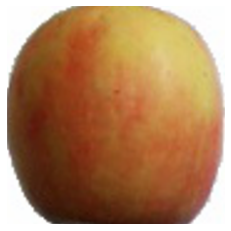

In [ ]:
imshow_tensor(sm)

#### Make predictions

In [ ]:
def predict(image_path, model, topk = 5):
  """Make a prediction for an image using a trained model"""

  real_class = image_path.split("/")[-2]

  # Convert to pytorch tensor
  img_tensor = process_image(image_path)

  #Resize 
  if train_on_gpu:
    img_tensor = img_tensor.view(1,3,224,224).cuda()
  else:
    img_tensor = img_tensor.view(1,3,224,224)


  # set to evaluation
  with torch.no_grad():
    model.eval()
    # Model outputs log probabilites
    out = model(img_tensor)
    ps = torch.exp(out)

    # Find the topk predictions
    topk, topclass = ps.topk(topk,dim =1)

    #Extract the actual classes and probabilities
    top_classes = [
                   idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]  # must convert tensor gpu -> tensor cpu 
    ]
    top_p = topk.cpu().numpy()[0]

    return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

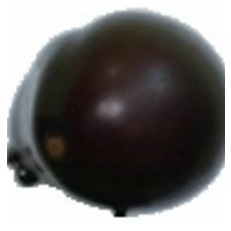

In [ ]:
# this function pick a random test image

def random_test_image(categories = None):
  """ Pick a random test image from the test dictionary"""
  if categories == None:
    c = np.random.choice(os.listdir(test_path))
    root = os.path.join(test_path, c)
  else:
    root = os.path.join(test_path,categories)
  
  img_path = os.path.join(root , np.random.choice(os.listdir(root)))
  return img_path

imshow_tensor(process_image(random_test_image()))

In [ ]:
img , top_p , top_classes , real_class  = predict(random_test_image(),model_best)
img.shape , top_p ,  top_classes, real_class

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(torch.Size([3, 224, 224]),
 array([1.0000000e+00, 4.4618659e-08, 1.1664497e-08, 1.8306282e-09,
        1.2550123e-09], dtype=float32),
 ['Peach 2',
  'Onion White',
  'Apple Red Yellow 2',
  'Apple Red 2',
  'Cherry Wax Yellow'],
 'Peach 2')

#### Display predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


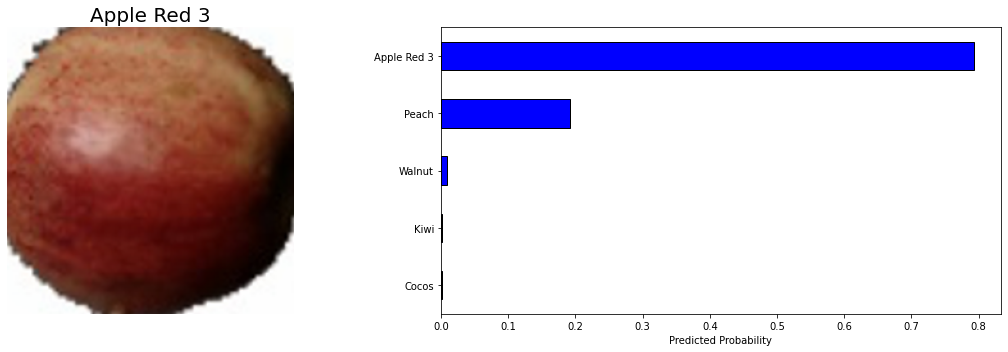

In [ ]:
def display_prediction(image_path, model, topk):
  """ Display image and predictions from model"""

  # get predictions
  img, ps , classes , y_obs = predict(image_path, model, topk)
  # Convert results to dataframe for plotting 
  result = pd.DataFrame({"p" : ps}, index = classes)

  # show the image
  plt.figure(figsize = (16,5))
  ax = plt.subplot(1,2,1)
  imshow_tensor(img, ax = ax)

  #set title to be the actual class
  ax.set_title(y_obs,size = 20)

  ax = plt.subplot(1,2,2)
  # plot a bar plot of prediction
  result.sort_values("p")["p"].plot.barh(color ="blue" , edgecolor = "k" , ax = ax)

  plt.xlabel("Predicted Probability")
  plt.tight_layout()

display_prediction(random_test_image(),model_best, topk = 5)

### Evaluation

#### Testing Accuracy 

In [ ]:
def accuracy(output , target , topk = (1,)):
  """ Compute the topk accuracy(s) """
  if train_on_gpu:
    output = output.to(device)
    target = target.to(device)

  with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    # Find the predicted classes  and transpose
    _ , pred = output.topk(k= maxk, dim =1 , largest = True , sorted = True)
    pred = pred.t()

    # Determine predictions equal to the targets
    correct = pred.eq(target.view(1,-1).expand_as(pred))
    res = []
  


    # for each k , find the percentage of correct 
    for k in topk:
      correct_k = correct[:k].reshape(-1).float().sum(0,keepdim = True)
      res.append(correct_k.mul_(100.0 / batch_size).item())
    return res

In [ ]:
testiter = iter(dataloaders["test"])
# get a batch of testing images and labels
features , targets = next(testiter)

if train_on_gpu:
  res = accuracy(model_best(features.to("cuda")),targets,topk = (1,5))
else : 
  res = accuracy(model_best(features),targets,topk = (1,5))

res

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[100.0, 100.0]

#### Evaluate Model Over all Classes

In [ ]:
def evaluate(model , test_loader, criterion , topk = (1,5)):
  """ Measure the performance of a trained pytorch model """
  classes = []
  losses = []
  # Hold accuracy results
  acc_results = np.zeros((len(test_loader)*batch_size, len(topk)))
  i = -1

  model.eval()

  with torch.no_grad():
    
    # Testing loop
    with tqdm(test_loader,unit="batch" ,desc= "Test",position=0, file=sys.stdout) as test:
      for data,  targets in test:
       
        if train_on_gpu:
          data, targets = data.to("cuda"), targets.to("cuda")

        # raw model ouput 
        out = model(data)
       
        #iterate through each example
     
        for pred , true in zip(out, targets):
          # Find topk accuracy
          
          acc_results[i,:] = accuracy(pred.unsqueeze(0) , true.unsqueeze(0),topk)
          # print(acc_results[i,:] )
          classes.append(idx_to_class[true.item()])
          # Calculate the loss
          loss = criterion(pred.view(1,number_class),true.view(1))
          losses.append(loss.item())
          i += 1
          
        
  # send results to a dataframe and calculate average across classes
  results = pd.DataFrame(acc_results,columns = [f"top{i}" for i in topk])
  results["class"] = classes
  results["loss"] = losses
  results = results.groupby(classes).mean()
  
  return results.reset_index().rename(columns = {"index":"class"})

In [ ]:
criterion = nn.NLLLoss()

# evaluate the model on all the testing data
results = evaluate(model_best,dataloaders["test"] ,criterion)
results.head()

Test: 100%|██████████| 709/709 [2:10:52<00:00, 11.08s/batch]


class       top1        top5      loss
0      Apple Braeburn  97.435897  100.000000  0.138080
1  Apple Crimson Snow  98.684211  100.000000  0.214583
2      Apple Golden 1  98.591549  100.000000  0.002881
3      Apple Golden 2  96.341463  100.000000  0.015855
4      Apple Golden 3  95.604396   98.901099  0.423059

In [ ]:
results.shape

(131, 13)

In [ ]:
results.to_csv(os.path.join(root,"evaluate.csv"))

#### Visualization results

(-5.0, 105.0)

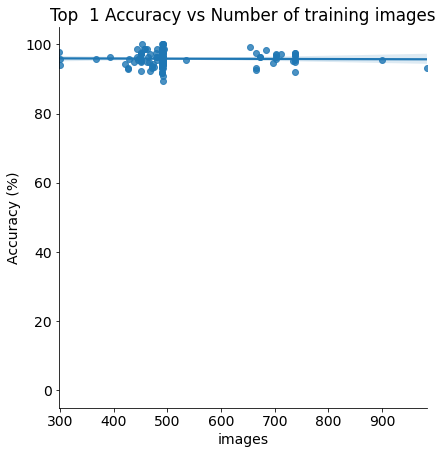

In [ ]:
results = pd.read_csv(os.path.join(root,"evaluate.csv"),index_col = 0)

cat_df = pd.read_csv(os.path.join(root,"df_cat.csv"),index_col = 0)
results = results.merge(cat_df, left_on = "class" , right_on = "Categories").\
drop(columns = ["Categories"])

# plot using seaborn 
sns.lmplot(y = "top1" , x = 'n_train' , data = results, height =6)
plt.xlabel('images')
plt.ylabel("Accuracy (%)")
plt.title("Top  1 Accuracy vs Number of training images")
plt.ylim(-5,105)

In [ ]:
print("Category with minimum accuracy.")
print(results.loc[results["top1"].idxmin])

print("Category with minimum images.")
print(results.loc[results["n_train"].idxmin])

Category with minimum accuracy.
class      Pomegranate
top1           89.4118
top5           98.8235
loss           1.12024
n_train            492
n_test             164
Name: 105, dtype: object
Category with minimum images.
class      Ginger Root
top1           97.8723
top5               100
loss        0.00319237
n_train            297
n_test              99
Name: 42, dtype: object


(-5.0, 105.0)

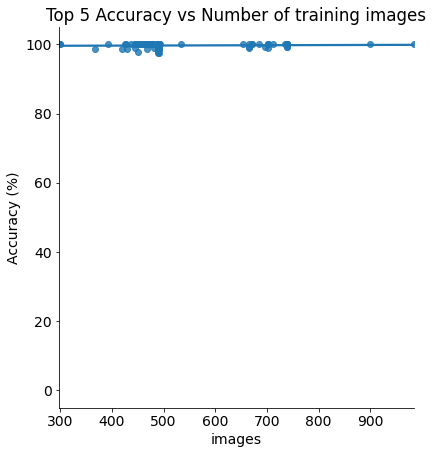

In [ ]:
sns.lmplot(
    y = "top5" ,x= "n_train" ,data = results ,height = 6
)
plt.xlabel("images")
plt.ylabel("Accuracy (%)")
plt.title("Top 5 Accuracy vs Number of training images")
plt.ylim(-5,105)

In [ ]:
# Weighted columns of test images
results["weighted"] = results["n_test"] / results["n_test"].sum()

# Create weighted accuracies
for i in (1,5):
  results[f"weighted_top{i}"] = results["weighted"] * results[f"top{i}"]

# Find final accuracy accounting for frequencies
top1_weighted = results["weighted_top1"].sum()
top5_weighted = results["weighted_top5"].sum()
loss_weighted = (results["weighted"] * results["loss"]).sum()

print(f"Final test cross entropy per image = {loss_weighted:.4f}.")
print(f"Final test top1 weighted accuracy = {top1_weighted:.2f}%")
print(f"Final test top5 weighted accuracy = {top5_weighted:.2f}%")

Final test cross entropy per image = 0.1510.
Final test top1 weighted accuracy = 95.85%
Final test top5 weighted accuracy = 99.69%


In [ ]:
results.loc[results["loss"].idxmax]

class              Eggplant
top1                92.3077
top5                98.7179
loss                2.36399
n_train                 468
n_test                  156
weighted         0.00687588
weighted_top1      0.634697
weighted_top5      0.678773
Name: 40, dtype: object

It's probably worth looking at the categories where the model is worst.

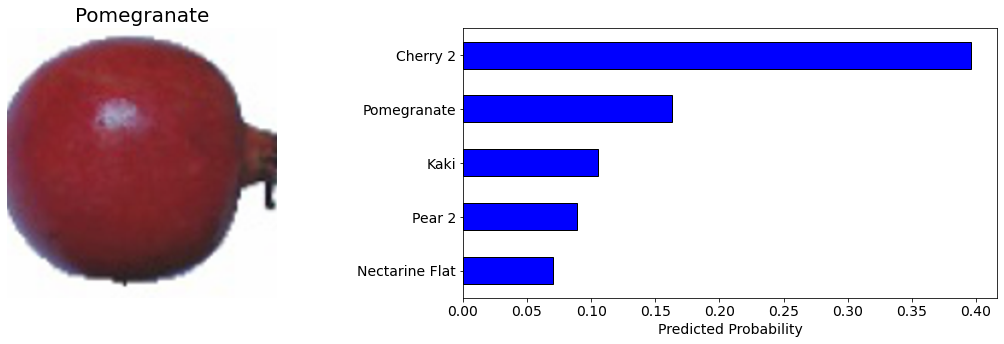

In [ ]:
egg = random_test_image("Pomegranate")

display_prediction(egg ,model_best, 5)

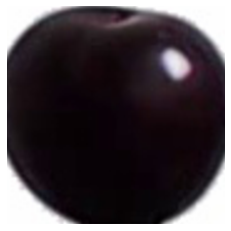

In [ ]:
imshow_tensor(process_image(random_test_image("Cherry Wax Black"))) # the same eggplant

           class       top1       top5     loss  n_train  n_test
105  Pomegranate  89.411765  98.823529  1.12024      492     164 



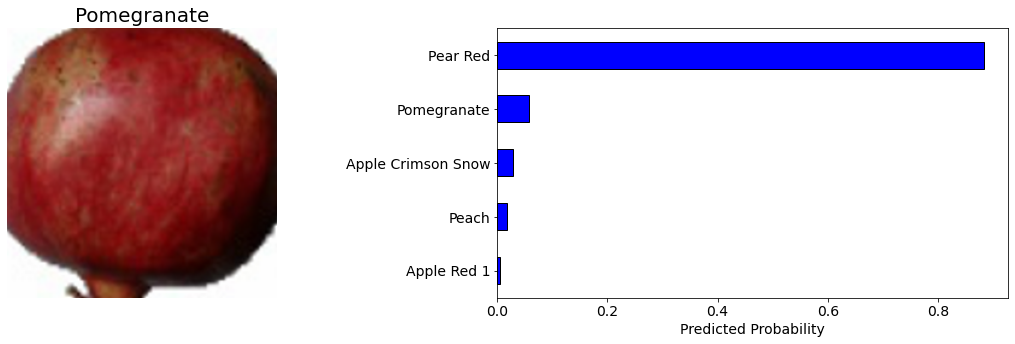

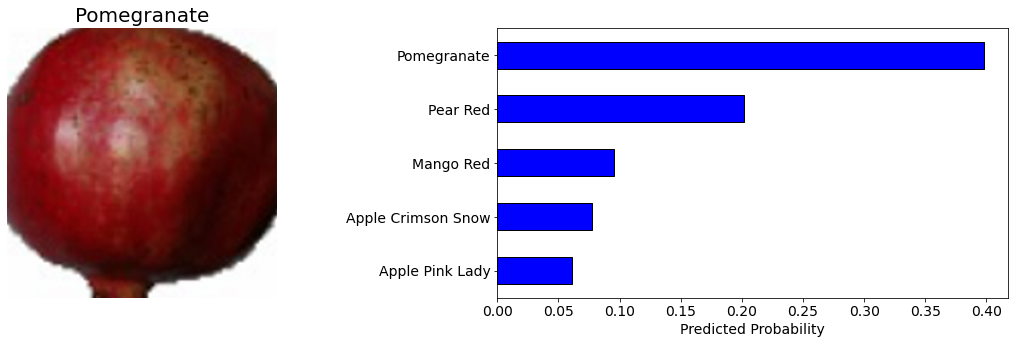

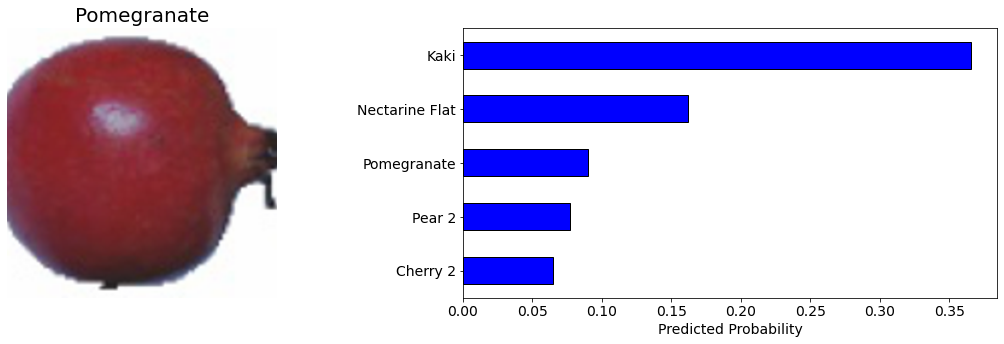

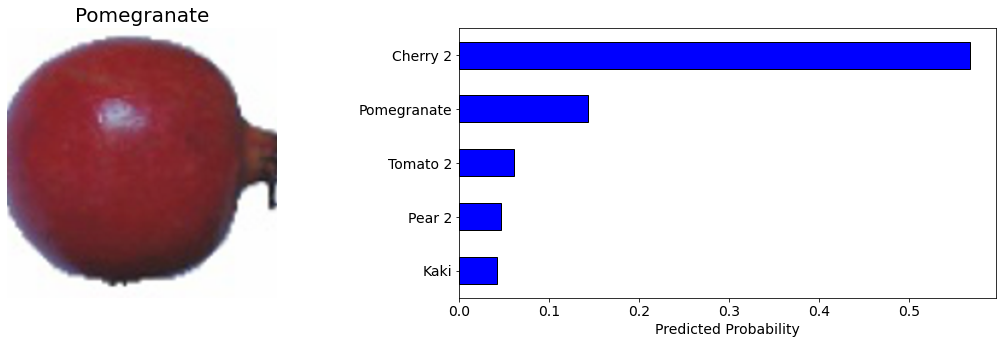

In [ ]:
def display_category(model, category , n_sample):
  """ Display predictions for a category """

  category_results = results.loc[results["class"] == category]
  print(category_results.iloc[:,:6],"\n")

  for i in range(n_sample):
    display_prediction(random_test_image(category),model,5)

display_category(model_best,"Pomegranate",4)

In [ ]:
model_best.eval()
with torch.no_grad():
  correct = 0
  total = 0
  with tqdm(dataloaders["test"]) as t:
    for images, labels in t:
      images = images.to(device)
      labels = labels.to(device)
      outputs  = model_best(images)
      _, predicted = torch.max(outputs.data,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('\nTest Accuracy of the model: {} %'.format(100 * correct / total))

100%|██████████| 709/709 [1:41:29<00:00,  8.59s/it]


Test Accuracy of the model: 95.84802538787024 %


In [ ]:
torch.save(model_best.state_dict(),os.path.join(root,"vgg_transfer.ckpt"))

#############################################################

### Load model pytorch and Evaluation multiple fruits

In [ ]:
model_best = VGG16(model_name)
model_best.load_state_dict(torch.load(os.path.join(root,"vgg_transfer.ckpt"),map_location=torch.device('cpu')))
model_best.eval();

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
for inputs, labels in dataloaders["train"]:
  print(inputs.shape)
  print(labels.shape)
  print(inputs.data.shape)
  break

torch.Size([16, 3, 100, 100])
torch.Size([16])
torch.Size([16, 3, 100, 100])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


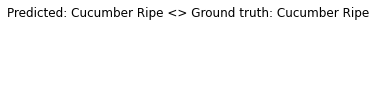

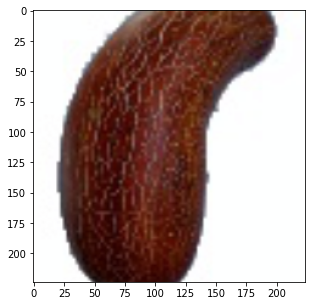

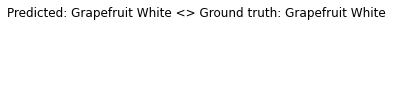

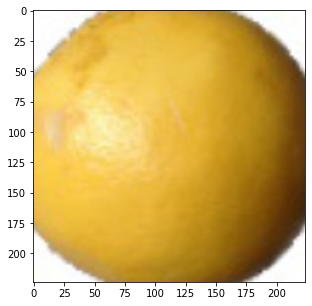

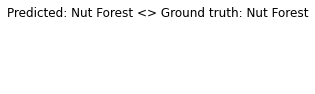

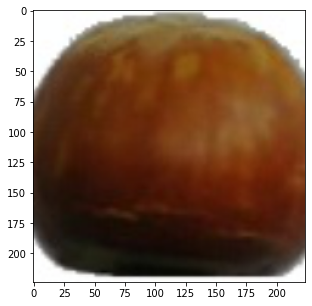

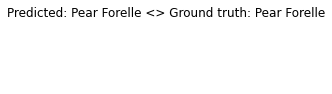

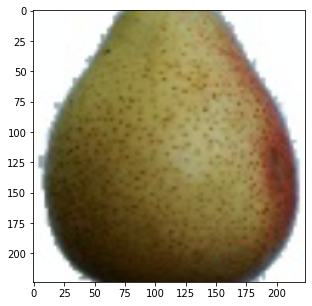

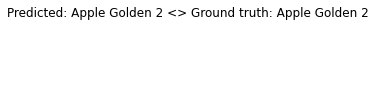

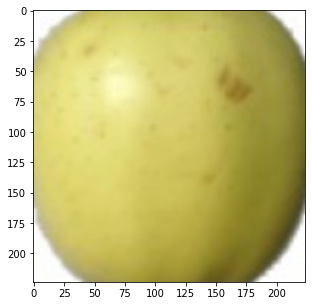

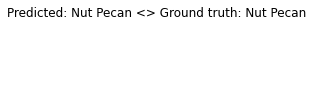

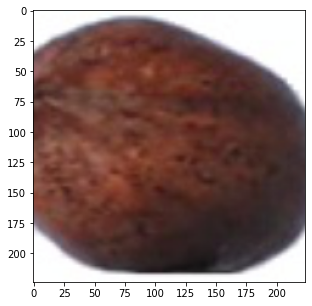

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted: {} <> Ground truth: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                imshow_gridtensor(inputs.cpu().data[j] , figsize= (10,5))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



visualize_model(model_best)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


kachi


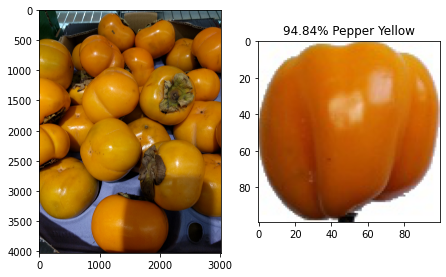

In [ ]:
from keras.preprocessing.image import load_img , img_to_array

transform_test  = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])

def test_multipletarget(model , link: str , estimate_number_target: int = None ):
  was_training = model.training 
  model.eval()
  
  
  targets = train_data.targets # list targets
  lc_subplot = 1

  # get the name picture
  name_title = link.split("/")[-1].split(".")[0]
  if estimate_number_target == None:
    estimate_number_target = len(name_title.split("_"))

  # create plot 
  fig = plt.figure(figsize = (15,10))
  # fig.suptitle(name_title)

  with torch.no_grad() :
    
    img = load_img(link) # only image PIL
    # img = img_to_array(img) 
    # print(transform_test(img).reshape(100,100,3))
    input = image_transforms['test'](img).float().unsqueeze(0)
    if torch.cuda.is_available():
      input = input.to(device)
    # Variable(image, requires_grad=True)
    out = model(input)

    ps = torch.exp(out)
    _,pred = torch.topk(ps.data,estimate_number_target)
    titles = []
    locations = []

    for index_label in pred[0]:
      titles.append(class_names[index_label])
      locations.append(targets.index(index_label))  # get local sample for predict

    print(name_title)
    # calculation number line plot test image
    number_line_plot = np.ceil((estimate_number_target +1 )/4)
    plt.subplots_adjust(wspace=0.2,hspace= 0.3)
    plt.subplot(number_line_plot,4,lc_subplot)
    # plt.title(name_title)
    plt.imshow(img)

   
    for index, al   in enumerate(zip(locations,titles,_[0])):
      local , lb , prob = al
      plt.subplot(number_line_plot,4,lc_subplot + index + 1)
      plt.imshow(train_data[local][0].numpy().transpose((1, 2, 0)))
      plt.title(f"{100*prob:.2f}% " + lb)
      # plt.imshow(train_data[local][0].reshape(100,100,-1)) # show multi picture
      # plt.imshow(dt[local][0])

    
    # fig.tight_layout()
  model.train(mode=was_training)
  # return img
image_name = "cocos_kiwi_orange_dates_salak_plum_tamarilo_maracuja3.jpg"
image_name = np.random.choice(os.listdir(os.path.join(root,"test-multiple_fruits")))

test_multipletarget(model_best,  os.path.join(root,"test-multiple_fruits",image_name))

### Conclusions

This project used the basics pytorch for deep learning. 
* Pytorch basics (based on ideas numpy)
* Data transformations
* Training data augmentation
* Transfer learning for object recognition
* Training a pytorch model with early stopping on a validation set
* Inference and evaluation using a pytorch model


#### Reference 
* https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet
* https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
* https://www.kaggle.com/yanniey/estimate-facial-age-with-keras-mobilenet-vgg1
* https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb
* https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/
* https://phamdinhkhanh.github.io/2019/08/10/PytorchTurtorial1.html
